# Importo Librerias

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier 
from xgboost.sklearn import XGBClassifier

In [174]:
pd.set_option('display.max_columns', None)

# Cargo Dataset

In [175]:
train = pd.read_csv(r'./data/train.csv')
test = pd.read_csv(r'./data/test.csv')

In [176]:
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [177]:
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [178]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [179]:
# Pclass deberia ser categorica (no int)
train['Pclass'] = train['Pclass'].astype('category')

In [180]:
# Divido variables categoricas y numericas para analizarlas por separado
categorical = train.select_dtypes(['category', 'object'])
numerical = train.drop(columns = ['PassengerId', 'Survived']).select_dtypes(['int64', 'float64'])

# Analisis de categoricas

In [181]:
categorical.describe()

,Pclass,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,204,889
unique,3,891,2,681,147,3
top,3,"Dooley, Mr. Patrick",male,347082,G6,S
freq,491,1,577,7,4,644


Las variables Sex y Pclass no demuestran problemas. La variable ticket tampoco. La variable Cabin tiene muchos nulls. Y la Variable embarked solo algunos nulls.

Voy a chequear distribucion de las variables categoricas para evaluar el balance de las categorias.

Name tiene 891 valores unicos, no va a servir como variable predictora en principio, voy a crear cuatro variables a partir de Name y luego la elimino

In [182]:
# Creo cuatro nuevas variables a partir de Name: MR, MRS, MISS, OTHER
train['MRS'] = train.Name.str.contains(r'\bMrs\b', regex=True).astype('int64')
train['MR'] = train.Name.str.contains(r'\bMr\b', regex=True).astype('int64')
train['MISS'] = train.Name.str.contains(r'\bMiss\b', regex=True).astype('int64')
list_other = []
for i in train.Name:
    if 'Mr' in i or 'Miss' in i:
        continue
    else: 
        list_other.append(i)
list_other2 = []
for i in range(len(train)):
    if train.Name[i] in list_other:
        list_other2.append(1)
    else:
        list_other2.append(0)
train['OTHER'] = list_other2

# Corrijo manualmente dos registros que tenian dos titulos al mismo tiempo (miss y mrs)
train.loc[[199, 427], 'MISS'] = 0

# Elimina variable Name
train = train.drop(columns= ['Name'])

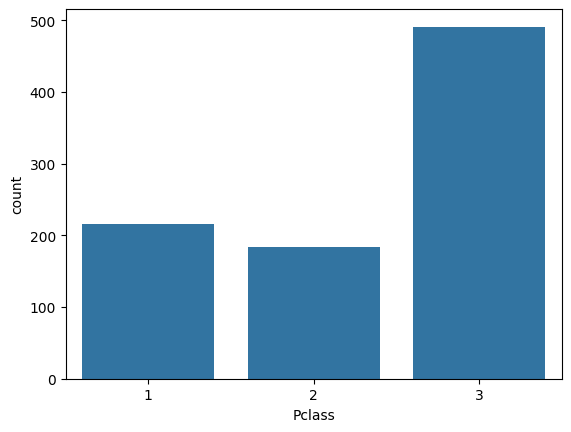

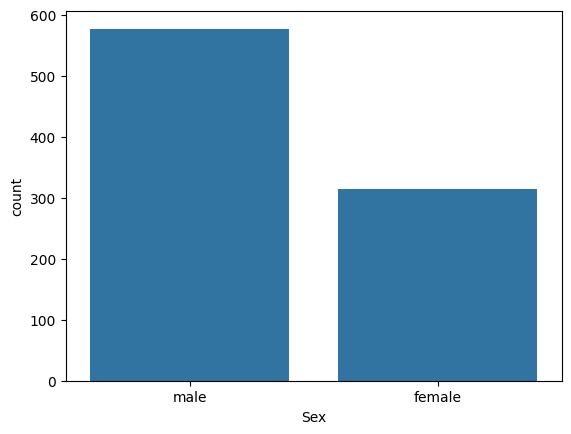

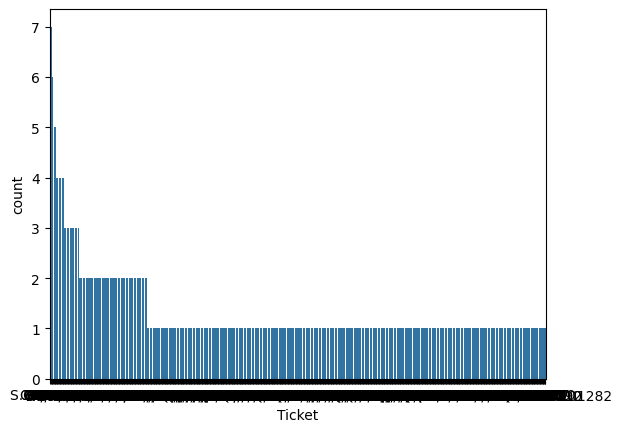

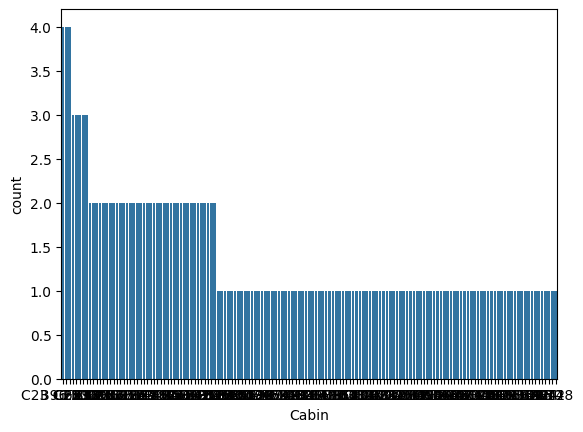

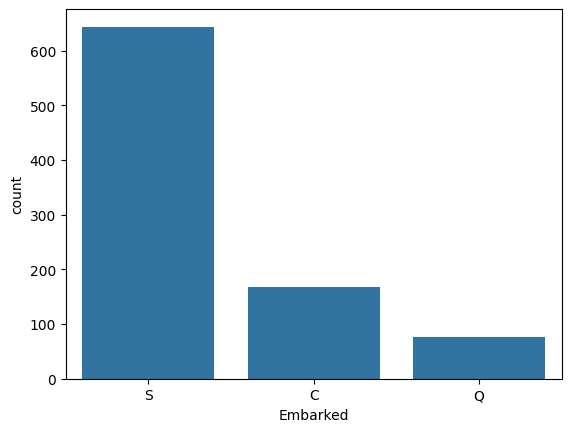

In [183]:
for i in categorical.drop('Name', axis=1).columns:
    sns.barplot(categorical[i].value_counts())
    plt.show()

En principio no parece haber valores extraños o valores nulos codificados en las variables categoricas. Abordare la alta cardinalidad de 'Ticket' y 'Cabin', y los valores nulos mas adelante.

# Analisis de Cuantitativas

In [184]:
numerical.describe()

,Age,SibSp,Parch,Fare
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,0.381594,32.204208
std,14.526497,1.102743,0.806057,49.693429
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,0.000000,7.910400
50%,28.000000,0.000000,0.000000,14.454200
75%,38.000000,1.000000,0.000000,31.000000
max,80.000000,8.000000,6.000000,512.329200


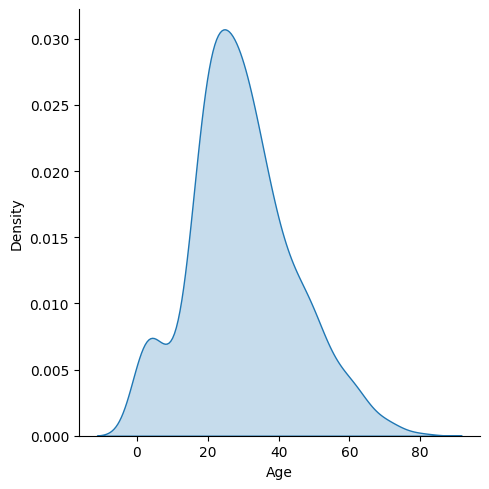

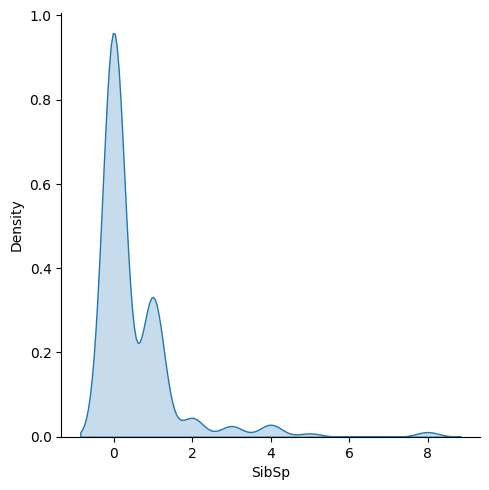

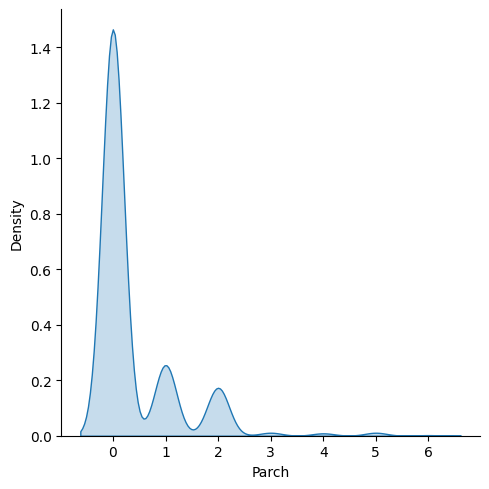

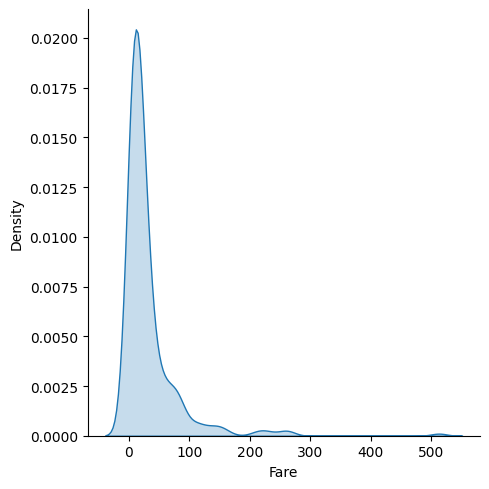

In [185]:
for i in numerical.columns:
    sns.displot(numerical[i], kind='kde', fill=True)
    plt.show()

Hay algunos valores nulos en Age. Las variables SibSp y ParCh podrian pasarse a categoricas. La variable Fare puede tener algunos outliers.

# Tratamiento de outliers

En esta etapa opte por winsorizar los valores outliers de la variable 'Fare'. Los valores outliers representaban un 6% de la muestra.

In [186]:
#Calculo primer cuartil
q1 = train.Fare.quantile(0.25)  
# Calcular tercer cuartil  
q3 = train.Fare.quantile(0.75)
# Calculo de IQR
IQR=q3-q1
# Calcular criterio (general para cualquier asimetría)
criterio = (train.Fare<(q1 - 3*IQR))|(train.Fare>(q3 + 3*IQR))
# Calculo porcentaje de outliers por debajo del criterio
lower = train.Fare[criterio&(train.Fare<q1)].count()/train.Fare.dropna().count()
# Calculo porcentaje de ouliers por encima del criterio
upper = train.Fare[criterio&(train.Fare>q3)].count()/train.Fare.dropna().count()

In [187]:
print('Porcentaje de valores outliers por debajo del criterio definido: {}'.format(lower))
print('Porcentaje de valores outliers por encima del criterio definido: {}'.format(upper))

Porcentaje de valores outliers por debajo del criterio definido: 0.0
Porcentaje de valores outliers por encima del criterio definido: 0.05948372615039282


In [188]:
# Calculo valor limite por encima del cual se definieron los outliers
limit = train.Fare.quantile(1- upper)
limit

np.float64(94.26882716049471)

In [189]:
# Modifico los valores outliers por encima del limite, colapsandolos al valor limite (winsorize)
train.loc[train.Fare > (q3+3*IQR), 'Fare'] = limit

In [190]:
# Chequeo que la winsorizacion haya tenido exito
print('Nuevo valor maximo de la variable: {}'.format(train.Fare.describe()['max']))

Nuevo valor maximo de la variable: 94.26882716049471


# Tratamiento de Nulos

In [191]:
train.apply(lambda x: x.isnull().sum()/len(train) *100)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
MRS             0.000000
MR              0.000000
MISS            0.000000
OTHER           0.000000
dtype: float64

'Age' tiene casi un 20% de nulos. Voy a probar algunas formas de imputacion para quedarme con la de mejor rendimiento.

'Cabin' tiene mas de un 75% de nulos. La voy a eliminar ya que imputar los nulos podria modificar negativamente la distribucion original de la variable.

In [192]:
train = train.drop('Cabin', axis=1)

In [193]:
nulls = train.apply(lambda x: x.isna().sum() / len(train) *100).round(3).sort_values(ascending=False)
columnas_imputar = nulls[nulls > 0].index.tolist()
columnas_imputar

['Age', 'Embarked']

In [194]:
import sklearn.impute as skl_imp
import feature_engine.imputation as fe_imp

# Construyo los imputadores con la librerias Scikit-learn
imputer_mean = fe_imp.MeanMedianImputer(imputation_method='mean')
imputer_knn = skl_imp.KNNImputer(n_neighbors=3)
imputer_rand = fe_imp.RandomSampleImputer(seed='general', random_state=1234)

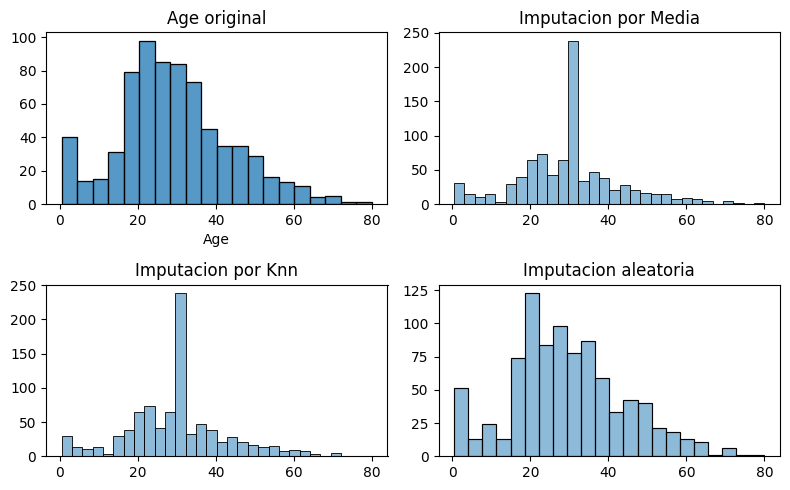

In [195]:
# Graficos para observar visualmente el impacto de las distintas estrategias de imputacion sobre la distribucion original de la variable
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (8,5))
sns.histplot(data= train, x= 'Age', ax = ax1)
sns.histplot(imputer_mean.fit_transform(train.Age.values.reshape(-1, 1)), ax=ax2, legend=False)
sns.histplot(imputer_knn.fit_transform(train[['Age']]), ax=ax3, legend=False)
sns.histplot(imputer_rand.fit_transform(train[['Age']]), ax=ax4, legend=False)
ax1.set_title('Age original')
ax2.set_title('Imputacion por Media')
ax3.set_title('Imputacion por Knn')
ax4.set_title('Imputacion aleatoria')
for i in [ax1,ax2,ax3,ax4]:
    i.set_ylabel('')
plt.tight_layout()

Como se puede apreciar en el grafico, la imputacion aleatoria es la que mas respeta la distribucion original de la variable, por lo que voy a elegir esta estrategia de imputacion.

In [196]:
train['Age'] = imputer_rand.fit_transform(train[['Age']])
test['Age'] = imputer_rand.transform(test[['Age']])

Dado que la variable 'Embarked' tiene muy pocos valores nulos y por simplicidad, voy a utilizar la misma estrategia de imputacion aleatoria para esta variable.

In [197]:
train['Embarked'] = imputer_rand.fit_transform(train[['Embarked']])
test['Embarked'] = imputer_rand.transform(test[['Embarked']])

In [198]:
# Chequeo que el proceso de imputacion haya sido exitoso
train.apply(lambda x: x.isnull().sum()/len(train) *100)

PassengerId    0.0
Survived       0.0
Pclass         0.0
Sex            0.0
Age            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
Embarked       0.0
MRS            0.0
MR             0.0
MISS           0.0
OTHER          0.0
dtype: float64

# Feature Engineering

### Tramificacion de Variables

In [199]:
# Defino la funcion para tramificar usando la libreria OptimalBinning
from optbinning import OptimalBinning
optb = OptimalBinning()
train['Parch_cat'] = optb.fit_transform(train['Parch'].values, train.Survived)
test['Parch_cat'] = optb.transform(test['Parch'].values)
train['SibSp_cat'] = optb.fit_transform(train['SibSp'].values, train.Survived)
test['SibSp_cat'] = optb.transform(test['SibSp'].values)

train['Parch_cat'] = train['Parch_cat'].astype('category')
train['SibSp_cat'] = train['SibSp_cat'].astype('category')

### Coding del Dataset

In [200]:
matrizcorr = pd.get_dummies(train.drop(['Ticket', 'PassengerId'], axis=1), dtype='int64', drop_first=True)
matrizcorr.head()

,Survived,Age,SibSp,Parch,Fare,MRS,MR,MISS,OTHER,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Parch_cat_-0.32565170564086077,Parch_cat_0.17374812415361393,SibSp_cat_0.16605677012004363,SibSp_cat_1.2443637926274076
0,0,22.0,1,0,7.2500,0,1,0,0,0,1,1,0,1,0,1,0,0
1,1,38.0,1,0,71.2833,1,0,0,0,0,0,0,0,0,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,0,0,1,0,0,1,0,1,1,0
3,1,35.0,1,0,53.1000,1,0,0,0,0,0,0,0,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,0,1,1,0,1,0,1,1,0


In [201]:
matrizcorr = matrizcorr.rename(columns={'Parch_cat_-0.32565170564086077': 'Parch_cat2', 'Parch_cat_0.17374812415361393': 'Parch_cat_3', 'SibSp_cat_0.16605677012004363': 'SibSp_cat_2',
                                 'SibSp_cat_1.2443637926274076': 'SibSp_cat_3'})

<Axes: >

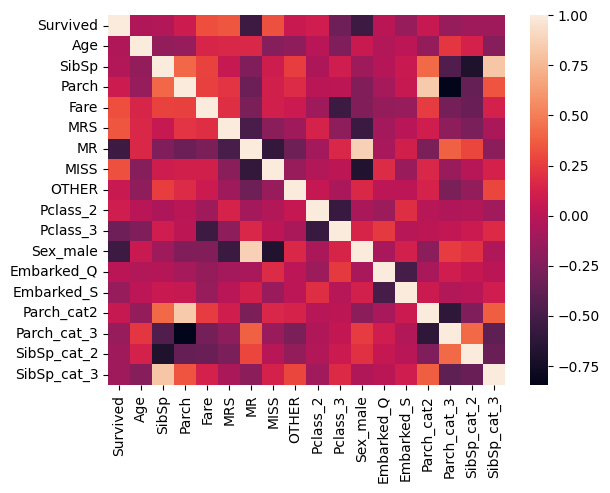

In [202]:
# Correlaciones entre las variables independientes entre si (colinealidad)
sns.heatmap(matrizcorr.corr())

In [203]:
# Correlacion con la variable objetivo
corr = abs(matrizcorr.corr())
corr[['Survived']].sort_values(by = 'Survived',ascending = False).style.background_gradient()

,Survived
Survived,1.000000
MR,0.546521
Sex_male,0.543351
MRS,0.344223
MISS,0.327106
Pclass_3,0.322308
Fare,0.319586
Embarked_S,0.149683
Parch_cat_3,0.147408
SibSp_cat_2,0.115867


La variable 'MR' parece redundante. Se correlaciona altamente con la variable 'Sex_male'. Por ende, la voy a eliminar

In [204]:
matriz = matrizcorr.drop('MR', axis=1)
matriz.insert(0, 'Const', 1)
matriz

,Const,Survived,Age,SibSp,Parch,Fare,MRS,MISS,OTHER,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Parch_cat2,Parch_cat_3,SibSp_cat_2,SibSp_cat_3
0,1,0,22.0,1,0,7.2500,0,0,0,0,1,1,0,1,0,1,0,0
1,1,1,38.0,1,0,71.2833,1,0,0,0,0,0,0,0,0,1,0,0
2,1,1,26.0,0,0,7.9250,0,1,0,0,1,0,0,1,0,1,1,0
3,1,1,35.0,1,0,53.1000,1,0,0,0,0,0,0,1,0,1,0,0
4,1,0,35.0,0,0,8.0500,0,0,0,0,1,1,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1,0,27.0,0,0,13.0000,0,0,1,1,0,1,0,1,0,1,1,0
887,1,1,19.0,0,0,30.0000,0,1,0,0,0,0,0,1,0,1,1,0
888,1,0,34.0,1,2,23.4500,0,1,0,0,1,0,0,1,1,0,0,0
889,1,1,26.0,0,0,30.0000,0,0,0,0,0,1,0,0,0,1,1,0


# Modelizacion

In [205]:
# Se define la funcion para evaluar los modelos con K fold cross validation
import warnings
def model_evaluation(models, score, X, y):
      results = []
      names = []
      #Para cada modelo
      for name, model in models:
          warnings.filterwarnings('ignore')
          # Genero un StratifiedKFold
          KF = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 98)

          # Hago cross_val
          cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

          # Guardo los resultados:
          results.append(cv_results)
          names.append(name)

          # Muestro los resultados numéricamente:
          print('Metric: {} , KFold '.format(str(score)))
          print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

      return None

In [206]:
# Preprocesamiento de los datos de test

test['Pclass'] = test['Pclass'].astype('category')
# Creo cuatro nuevas variables a partir de Name: MR, MRS, MISS, OTHER
test['MRS'] = test.Name.str.contains(r'\bMrs\b', regex=True).astype('int64')
test['MR'] = test.Name.str.contains(r'\bMr\b', regex=True).astype('int64')
test['MISS'] = test.Name.str.contains(r'\bMiss\b', regex=True).astype('int64')
list_other = []
for i in test.Name:
    if 'Mr' in i or 'Miss' in i:
        continue
    else: 
        list_other.append(i)
list_other2 = []
for i in range(len(test)):
    if test.Name[i] in list_other:
        list_other2.append(1)
    else:
        list_other2.append(0)
test['OTHER'] = list_other2


# Elimina variable Name
test = test.drop(columns= ['Name'])


# Modifico los valores outliers por encima del limite, colapsandolos al valor limite (winsorize)
test.loc[test.Fare > (q3+3*IQR), 'Fare'] = limit
test.Fare = test.Fare.fillna(train.Fare.mean())    # Fare tenia un valor nulo que impedia que corriera correctamente el modelo

test = test.drop(['Cabin', 'MR'], axis=1)

test['Parch_cat'] = test['Parch_cat'].astype('category')
test['SibSp_cat'] = test['SibSp_cat'].astype('category')

matriz_test = pd.get_dummies(test.drop(['Ticket', 'PassengerId'], axis=1), dtype='int64', drop_first=True)
matriz_test = matriz_test.rename(columns={'Parch_cat_-0.32565170564086077': 'Parch_cat2', 'Parch_cat_0.17374812415361393': 'Parch_cat_3', 'SibSp_cat_0.16605677012004363': 'SibSp_cat_2',
                                 'SibSp_cat_1.2443637926274076': 'SibSp_cat_3'})
matriz_test.insert(0, 'Const', 1)

In [207]:
# Escalo los datos
scaler = StandardScaler()
matriz = pd.DataFrame(scaler.fit_transform(matriz.drop('Survived', axis=1)), columns=matriz.drop('Survived', axis=1).columns.values)
matriz_test = pd.DataFrame(scaler.transform(matriz_test), columns=matriz_test.columns.values)

In [208]:
# Realizo la particion train-test (80/20) sobre los datos del df de entrenamiento para luego evaluar y validar los modelos
X = matriz
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify= y, random_state=1234)

In [209]:
# Instancio los modelos y aplico la funcion de evaluacion definida previamente sobre cada uno.
models = [
         ("GaussianNB",GaussianNB()),
         ('LogisticRegression', LogisticRegression(random_state=1234)),
         ('LinearSVC', LinearSVC(random_state=1234)),
         ('KNNClassifier', KNeighborsClassifier()),
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("RandomForestClassifier", RandomForestClassifier(random_state=1234, n_estimators=10)),
         ('XGBoostClassifier', XGBClassifier(random_state=1234))
]

evaluation_score = "accuracy"

model_evaluation(models,  evaluation_score, X_train, y_train)

Metric: accuracy , KFold 
GaussianNB: 0.793564 (0.028682) 
Metric: accuracy , KFold 
LogisticRegression: 0.807629 (0.031765) 
Metric: accuracy , KFold 
LinearSVC: 0.814632 (0.036874) 
Metric: accuracy , KFold 
KNNClassifier: 0.820168 (0.041864) 
Metric: accuracy , KFold 
DecisionTreeClassifier: 0.770970 (0.039323) 
Metric: accuracy , KFold 
RandomForestClassifier: 0.796381 (0.043949) 
Metric: accuracy , KFold 
XGBoostClassifier: 0.803326 (0.042435) 


In [210]:
# Construyo el diccionario con listas de hiperparametros a ser evaluados por grid_search
model = KNeighborsClassifier()
weights = ['uniform', 'distance'] 
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
p = [1, 2]


grid = dict(weights=weights, algorithm= algorithm, p= p)

In [211]:
# Instancio el objeto grid_search
cv = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [212]:
# Entreno el objeto grid_search
grid_result = grid_search.fit(X_train, y_train)
print("Mejor accuracy: %f usando los parámetros %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor accuracy: 0.810361 usando los parámetros {'algorithm': 'auto', 'p': 2, 'weights': 'uniform'}


In [213]:
# Entreno el modelo final con los hiperparametros previamente especificados por grid_search
knnclf = KNeighborsClassifier(algorithm='auto', p=2, weights='uniform')
# Ajusto el modelo a los datos de entrenamiento
knnclf.fit(X_train,y_train)

KNeighborsClassifier()

In [214]:
# Realizo un predict sobre el set de test para luego construir la matriz de confusion y el classification report
from sklearn.metrics import classification_report
y_pred = knnclf.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       110
           1       0.77      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



# Submission

In [215]:
matriz_test = pd.concat([matriz_test, test.PassengerId], axis=1)

In [216]:
knnclf = KNeighborsClassifier(algorithm='auto', p=2, weights='uniform')
knnclf.fit(X, y)

KNeighborsClassifier()

In [217]:
predicciones = knnclf.predict(matriz_test.drop(columns='PassengerId'))
predicciones = pd.Series(predicciones)
submission = pd.DataFrame(data= predicciones.values, index= matriz_test['PassengerId'].values)
submission.columns = ['Survived']
submission.index.name = 'PassengerId'

In [218]:
submission.to_csv(r'./results/Knnclf.csv')

# VotingClassifier

In [219]:
clf1 = XGBClassifier(colsample_bytree= 0.2, eta= 0.2, n_estimators= 100, max_depth=12, random_state=1234)
clf2 = LogisticRegression(C=0.1, solver='lbfgs')
clf3 = KNeighborsClassifier(algorithm='auto', p=2, weights='uniform')
eclf = VotingClassifier(estimators=[
    ('xgboost', clf1), ('logreg', clf2), ('KNN', clf3)], voting='hard')   ## Se intentó con voting 'hard', pero 'soft' da mejor resultado en la competencia
eclf.fit(X, y)

VotingClassifier(estimators=[('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.2, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False, eta=0.2,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=12,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None, ...)),
                             ('logreg', LogisticRegression(C=0.1)),
                             ('KNN', KNeighborsClassifier())])

In [220]:
predicciones = eclf.predict(matriz_test.drop(columns='PassengerId'))
predicciones = pd.Series(predicciones)
submission = pd.DataFrame(data= predicciones.values, index= matriz_test['PassengerId'].values)
submission.columns = ['Survived']
submission.index.name = 'PassengerId'

In [221]:
submission.to_csv(r'./results/Votingclf.csv')